* The code in this file implements the randomized svd based on the pseudocodes of the rsvd library.
* The rsvd library and its write up can be found at: https://github.com/erichson/rSVD and https://arxiv.org/pdf/1608.02148.pdf

In [1]:
import pandas as pandas
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import time

# Generating the Matrix A

* We aim to generate Matrix $A$ with a specified singular values.
    1. We generate $A = UPV$, where $U$ and $V$ are random matrices.
    2. $U$ and $V$ have very high chance of being full rank due to the probability.
    3. Entries of P is same as the singular values of $A$. Order can be different.
    4. It is very important to use $QR$ to $U$ and $V$ before multiplying $U,P,V$
    5. Below example generates $P$ with a gradual decay.

[[ 0.00187754  0.00357869  0.00346585 ...  0.00311212  0.00066869
  -0.00090731]
 [-0.00308587 -0.00069838 -0.00144602 ...  0.00178283  0.00576016
   0.00111738]
 [ 0.0009192   0.00254653 -0.00176132 ...  0.00111145 -0.00368896
  -0.00218082]
 ...
 [ 0.00443139  0.00237953  0.00191118 ...  0.00532086  0.00027311
   0.00034106]
 [ 0.00184668  0.00096472  0.00320632 ...  0.00094202 -0.0024663
   0.0003631 ]
 [-0.00469621 -0.00095278  0.00529136 ...  0.00255678 -0.00170393
  -0.00051253]]


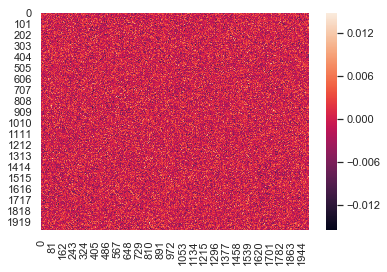

In [2]:
# A is mxn and rank k.
# Diagonal entries of P is same as the singular values of A.
# numpy.random.rand() has uniform continuous distribution on [0,1]
m,n,k = 2000,2000,120
randU = np.random.rand(m,m)
randV = np.random.rand(n,n)

# If you don't use QR and then multiply, there will be one large singular value.
# Using QR gives us same singular value for A as P
randU, r = np.linalg.qr(randU)
randV, r = np.linalg.qr(randV)

sig = np.random.choice(100, k)/100
sig = np.asarray(sig.tolist() + (np.zeros(m-k)).tolist())
P = np.diag(sig)

# matmul is quite slow...
A = np.matmul(randU,P) #You can't just use *!!! You have to use matmul function.
A = np.matmul(A,randV)
print(A) 

import seaborn as sns; sns.set()
ax = sns.heatmap(A)

# rsvd implementation in python

* Step1: compute $Q$  used in $A\approx Q Q^T A = QB$
    1. Generate Random Matrix $\Omega$
    2. Preprocess $A$ to $A^{(q)} := (AA^T)^{(q)}A$
    3. Apply QR-decomp to $Y:=A\Omega = QR$
         * number 2 and 3 are done simultaneously

In [3]:
# Generate Random Matrix Omega(nxk)
q = 2 # Preprocessing (page 9 of the write up of rsvd) for better computation, applied later with Y
k = 30 # How many random vectors you want to use -> changes the size of Omega.
p = 10 # OverSampling
l = k+p # l is lowercase L
Omega = []
for i in list(range(0,l)):
    w = (np.random.choice(int(n/10),n))/100 # n is the column number of A
    Omega.append(w)
print(Omega) # Omega is a collection of k+p random vectors
Omega = np.column_stack(Omega) # Merge all k+p vectors into a matrix Omega.
print(Omega)

[array([1.34, 1.46, 1.32, ..., 1.93, 1.36, 1.35]), array([0.1 , 0.67, 0.44, ..., 1.94, 0.22, 0.37]), array([0.05, 1.51, 1.37, ..., 1.89, 0.38, 1.34]), array([1.55, 1.37, 0.02, ..., 0.36, 0.63, 1.69]), array([0.8 , 0.1 , 0.68, ..., 0.86, 1.62, 1.57]), array([0.36, 0.39, 1.55, ..., 1.57, 0.9 , 1.06]), array([0.84, 1.56, 0.63, ..., 1.09, 1.51, 1.2 ]), array([0.  , 0.08, 1.83, ..., 0.89, 1.44, 0.62]), array([1.04, 0.13, 1.52, ..., 1.61, 1.2 , 0.22]), array([1.44, 0.99, 1.03, ..., 0.98, 0.12, 1.81]), array([0.33, 0.14, 1.76, ..., 1.56, 0.76, 1.48]), array([0.79, 0.28, 0.68, ..., 1.45, 0.72, 0.36]), array([0.89, 0.59, 1.77, ..., 1.59, 1.09, 1.18]), array([1.38, 1.33, 0.88, ..., 1.56, 1.87, 0.23]), array([0.28, 0.72, 1.93, ..., 0.16, 0.13, 1.33]), array([1.14, 1.42, 1.4 , ..., 0.24, 1.66, 1.16]), array([0.93, 1.24, 0.96, ..., 1.45, 0.92, 0.12]), array([1.19, 0.  , 0.66, ..., 0.21, 1.67, 0.92]), array([0.89, 1.91, 1.73, ..., 1.17, 0.21, 0.43]), array([0.38, 1.81, 1.64, ..., 1.18, 0.  , 1.26]),

In [4]:
# Apply QR-decomp to A*Omega with preprocess amount q (refer to page 9 in the write up by Erichson)
Y = np.matmul(A,Omega)
for i in list(range(0,q)):
    Q, R = np.linalg.qr(Y)
    Q, R = np.linalg.qr(np.matmul(np.transpose(A), Q))
    Y = np.matmul(A,Q)
Q, R = np.linalg.qr(Y)

* Step2: $A \approx QQ^{T}A = QB = Q\hat{U}\Sigma V^{T} = U\Sigma V^{T}$

In [5]:
# Apply traditional svd on B and gain approx svd for A
B = np.matmul(np.transpose(Q),A)
U_hat, S, V_t = np.linalg.svd(B)
U = np.matmul(Q,U_hat)
# Now svd for A is approximately U, S, V_t

* Now, we can calculate true svd and compare.

In [6]:
# True SVD of A
U2,S2,V2 = np.linalg.svd(A)

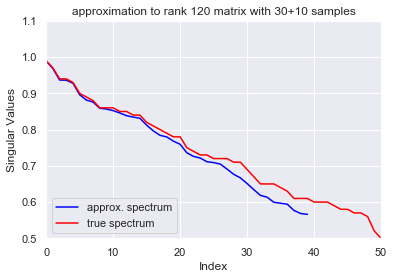

In [7]:
plt.plot(S,color = "blue",label='approx. spectrum')
plt.plot(S2,color="red",label='true spectrum')
plt.xlim(0,50)
plt.ylim(0.5,1.1)
plt.title("approximation to rank 120 matrix with 30+10 samples")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.legend(loc='lower left')
plt.show()

In [8]:
# Difference in size of the approximated spectrum and the true spectrum. It is very small.
concS2 = S2[:40]
diff = np.linalg.norm(concS2-S)
print(diff)

0.1490661054850338


* Below is the function version of rsvd
    * Keep the default parameters in mind

In [9]:
# @ A input matrix
# @ q preprocessing amount
# @ k sample amount
# @ p oversample amount
def rsvd(A,q=2,k=30,p=10):
    l = k+p
    Omega = []
    for i in list(range(0,l)):
        w = (np.random.choice(int(n/10),n))/100
        Omega.append(w)
    Omega = np.column_stack(Omega)
    Y = np.matmul(A,Omega)
    for i in list(range(0,q)):
        Q, R = np.linalg.qr(Y)
        Q, R = np.linalg.qr(np.matmul(np.transpose(A), Q))
        Y = np.matmul(A,Q)
    Q, R = np.linalg.qr(Y)
    B = np.matmul(np.transpose(Q),A)
    U_hat, S, V_t = np.linalg.svd(B)
    U = np.matmul(Q,U_hat)
    return U, S, V_t

# Diverse Insights

* Power of Preprocessing
    * Decay in spectrum for preprocessed and non-preprocessed matrices (page 8 of rsvd write up by Erichson)
    * The result evidently shows that the decay gets faster with preprocessing.
    * This means that the data A becomes better for approximating

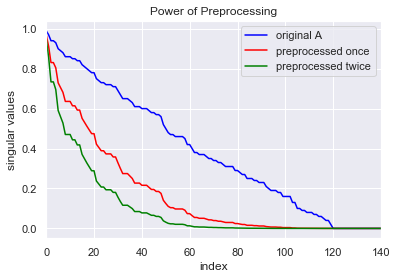

In [10]:
# True Spectrum vs Preprocessed Spectrum
U2,S2,V2 = np.linalg.svd(A)
AAT = np.matmul(A,np.transpose(A))
A_1 = np.matmul(AAT,A)
U3,S3,V3 = np.linalg.svd(A_1)
A_2 = np.matmul(AAT,A_1)
U4,S4,V4 = np.linalg.svd(A_2)

plt.plot(S2,color = "blue",label='original A')
plt.plot(S3,color="red",label='preprocessed once')
plt.plot(S4,color="green", label='preprocessed twice')
plt.title('Power of Preprocessing')
plt.xlim(0,140)
plt.xlabel('index')
plt.ylabel('singular values')
plt.legend(loc='upper right')
plt.show()

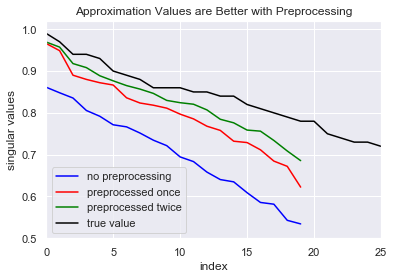

In [11]:
# p is a place holder here
p,s1,p = rsvd(A,q=0,k=10)
p,s2,p = rsvd(A,q=1,k=10)
p,s3,p = rsvd(A,q=2,k=10)
p,s4,p = np.linalg.svd(A)
plt.plot(s1,color="blue",label='no preprocessing')
plt.plot(s2,color="red",label='preprocessed once')
plt.plot(s3,color="green",label='preprocessed twice')
plt.plot(s4,color="black", label='true value')
plt.xlim(0,25)
plt.ylim(0.5, 1.02)
plt.title('Approximation Values are Better with Preprocessing')
plt.xlabel('index')
plt.ylabel('singular values')
plt.legend(loc='lower left')
plt.show()

* Sampling amount and Oversampling
    * More sampling means more stable
    * Oversampling by few more helps a lot

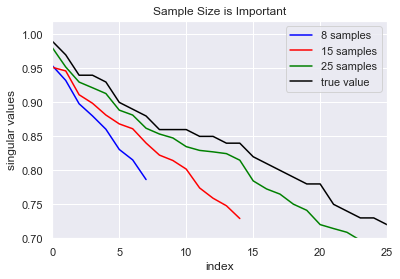

In [12]:
# p is a place holder here. set oversampling to 0
p,s1,p = rsvd(A,k=8,p=0)
p,s2,p = rsvd(A,k=15,p=0)
p,s3,p = rsvd(A,k=25,p=0)
#p,s4,p = np.linalg.svd(A) #calculated from before
plt.plot(s1,color="blue",label='8 samples')
plt.plot(s2,color="red",label='15 samples')
plt.plot(s3,color="green",label='25 samples')
plt.plot(s4,color="black", label='true value')
plt.xlim(0,25)
plt.ylim(0.7,1.02)
plt.title('Sample Size is Important')
plt.xlabel('index')
plt.ylabel('singular values')
plt.legend(loc='upper right')
plt.show()

* Sparsity of a Matrix

* Spectral Decay of a Matrix

# Time Comparison

In [13]:
import time

In [14]:
#### normal svd

start = time.time()
U2,S2,V2 = np.linalg.svd(A)
end = time.time()

print(end-start)

6.572836875915527


In [15]:
#### rsvd with q=2 k=30 => 10 times faster than normal svd

start = time.time()
u,s,v = rsvd(A,q=2,k=30)
end = time.time()

print(end-start)

0.8183844089508057


# Consideration & Discussion

* Difference in Computing for rapid decaying spectrum and slow decaying spectrum
* Difference in Computing for Sparsity of a Matrix

* research idea: Changing algorithms according to the shape and sparsity of a matrix?